In [1]:
# Import libraries. You may or may not use all of these.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


2023-01-10 18:04:03.014868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import data
#!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()


,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
# Train test split
import pandas as pd
from sklearn.model_selection import train_test_split

target_variable = 'expenses'
size_training_data = 0.8

# Split training and testing data
X_train, X_test, train_labels, test_labels = train_test_split(dataset.drop(target_variable,
                                                                    axis = 'columns'),
                                                    dataset[target_variable],
                                                    train_size   = size_training_data,
                                                    random_state = 123,
                                                    shuffle      = True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

del size_training_data


In [4]:
# Data preparation: "scaling" and "one hot encoding"
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

# One-hot-encoding de las columnas cualitativas, "dummy encoding" si es binaria (drop = 'if_binary')
# Mantener columnas a las que no se les aplica ninguna transformación: (remainder = 'passthrough')
numeric_cols = X_train.select_dtypes(include = ['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include = ['object', 'category','bool']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', RobustScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown = 'error', drop = 'if_binary'), cat_cols)],
                remainder = 'passthrough')
# Aplicar el transformer
train_dataset = preprocessor.fit_transform(X_train)
test_dataset = preprocessor.transform(X_test)

# Convertir el output en dataframe y añadir el nombre de las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
train_dataset = pd.DataFrame(train_dataset, columns = labels, index = X_train.index)
test_dataset = pd.DataFrame(test_dataset, columns = labels, index = X_test.index)
train_dataset.info()

del numeric_cols, cat_cols, preprocessor, encoded_cat, labels, X_train, X_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1070 non-null   float64
 1   bmi               1070 non-null   float64
 2   children          1070 non-null   float64
 3   sex_male          1070 non-null   float64
 4   smoker_yes        1070 non-null   float64
 5   region_northeast  1070 non-null   float64
 6   region_northwest  1070 non-null   float64
 7   region_southeast  1070 non-null   float64
 8   region_southwest  1070 non-null   float64
dtypes: float64(9)
memory usage: 75.4 KB


In [47]:
# Create the architecture of the Neural Network #
########## with BASELINE hyperparameters ########
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

def get_tf_model(n_features, dropout1=0.0, dropout2=0.0,learnRate=0.001,unitshiddenLayer1=2,
    wrl2_1=0.0,wrl2_2= 0.0):
    # Initialize a sequential model and add layers etc.
    model = keras.Sequential()
    model.add(keras.Input(shape=n_features))
    model.add(BatchNormalization())
    model.add(layers.Dense(units = n_features, kernel_regularizer=regularizers.L2(wrl2_1), activation="relu"))
    model.add(Dropout(dropout1))
    model.add(layers.Dense(units = unitshiddenLayer1, kernel_regularizer=regularizers.L2(wrl2_2), activation="relu"))
    model.add(Dropout(dropout2))
    model.add(layers.Dense(units = 1, activation="relu"))

    # Compile the model
    model.compile(
        loss      = "mae",                         # Adaptar la métrica de validación: "accuracy", "mse", "mae"
        metrics   = ["mae", "mse"],
        optimizer = tf.optimizers.Adam(learning_rate = learnRate)) # Adamax
    # return compiled model
    return model

# Callback to reduce the risk of overfitting:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr]


/home/chris/miniconda3/envs/my_ml_env_39/lib/python3.9/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



Epoch 196: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 205: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 211: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 215: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 215: early stopping
Train error 4074.470458984375
Test error  3491.35205078125


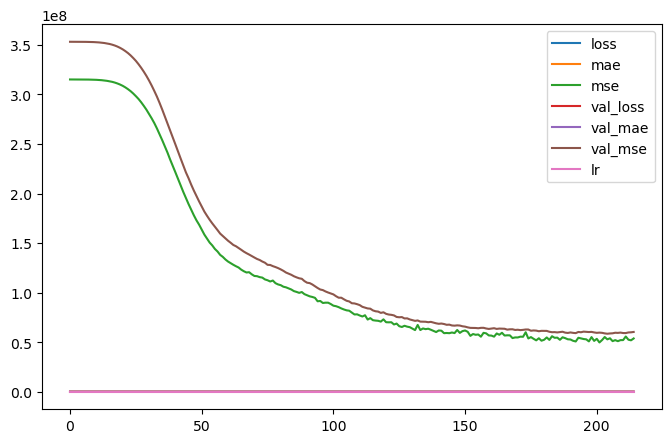

In [48]:
# Train model
import pandas as pd
import tensorflow as tf
from numpy.random import seed
from matplotlib import pyplot as plt

seed(123)
tf.random.set_seed(123)

# Initialize our model with the default hyperparameter values
model = get_tf_model(n_features=train_dataset.shape[1])

# train the network
history = model.fit(x = train_dataset,
                        y = train_labels,
                        epochs = 250,
                        validation_split = 0.1,
                        verbose = 0,
                        callbacks = callbacks_list)
# Compute test error
score_test = model.evaluate(x=test_dataset, y=test_labels, verbose = 0)

# Print results
print('Train error', history.history['val_loss'][-1])
print('Test error ', score_test[0]) # o era 1?

# Plot training and validation history
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


9/9 - 0s - loss: 3491.3521 - mae: 3491.3521 - mse: 44639548.0000 - 31ms/epoch - 3ms/step
Testing set Mean Abs Error: 3491.35 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 2ms/step


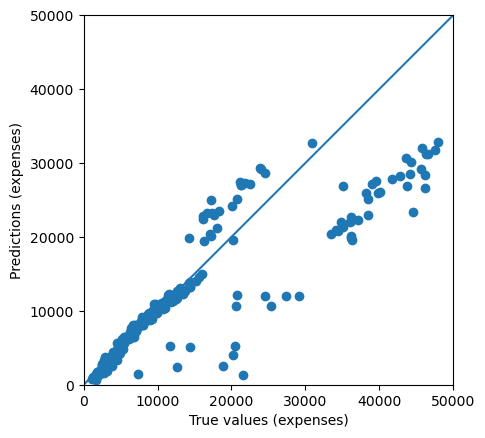

In [49]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
